<a href="https://colab.research.google.com/github/stevejobws/Colaboratory/blob/master/gcn_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torchtext
!pip install torchvision
!pip install torch_sparse -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install torch_scatter -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install torch_geometric # 下载安装pytorch_geometric
!pip install networkx # 画图
import torch
import torch.nn.functional as F
import torch_geometric 
from torch_geometric.nn import GCNConv, ChebConv

In [ ]:
! python -c "import torch_geometric; print(torch_geometric.__version__)" # 检查是否安装成功

In [ ]:
! uname -a  # 查看系统  
! python --version  # 查看python版本 
! python -c 'import torch; print(torch.version.cuda)' # 查看cuda的版本，检查是否和cuda的一致
! nvcc --version # 查看nvcc版本 

Linux e4e606ebf6e4 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux
Python 3.6.9
10.1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
print(torch.version.cuda) # torch的cuda版本

10.1


In [ ]:
import torch
print("hello torch{}".format(torch.__version__))


hello torch1.6.0+cu101


# 1. 预处理数据集的格式，转化为GCN所需要的格式

In [1]:
import tensorflow as tf # Orange 1.14.0
print(tf.__version__)
import keras # 2.2.5
print(keras.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
2.2.5


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [27]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.5

     |████████████████████████████████| 109.2MB 51kB/s 
     |████████████████████████████████| 3.2MB 33.0MB/s 
     |████████████████████████████████| 491kB 38.4MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


     |████████████████████████████████| 337kB 3.4MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


### 1.1 import file is  attribute of node

In [2]:
import pandas as pd
import numpy as np
node_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNodeAttribute.csv',header = None) 
num = node_features.shape[0] # Number of nodes
node_features  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0,0.770633,0.010733,0.582718,-0.062620,-0.238564,-0.715823,1.022981,0.181646,-0.260391,-0.542033,0.233139,-0.283432,0.117144,0.531449,-0.061221,-0.229529,-0.710597,0.288485,0.098411,0.189655,-0.511962,-0.263284,0.078329,0.198719,1.086848,-0.256804,0.026246,0.093899,-0.142497,0.018819,-0.234937,-0.153423,0.425772,0.673969,0.025525,-0.294841,-0.315873,0.552618,0.437355,-0.087442,0.536133,-0.366451,0.656990,0.802005,-0.016102,-0.669421,0.856563,-0.101192,-0.165583,-0.405513,-0.410948,-0.027975,-0.397765,-0.509387,0.280567,0.208776,-0.099218,-0.229354,0.232348,-1.035032,1.209129,0.368444,0.414352,-1.065435
1,1,2.882159,1.241338,2.232549,-1.932836,-0.574318,0.168684,2.937954,1.398610,-0.260359,-1.253366,-0.997117,-1.355796,0.847303,2.447680,-0.573743,0.211870,-0.960837,1.536916,2.928266,-0.955619,-1.152885,0.548847,0.525967,-0.445511,2.999283,0.190644,-0.916012,0.877579,1.501392,-2.191907,-0.344929,-0.643345,1.808293,0.922850,0.823318,0.399970,0.415868,0.005898,-2.257816,-0.475472,0.610879,-1.345582,1.256365,0.962199,-1.093309,-1.647974,1.594285,0.584256,-1.293162,-1.844852,-0.580833,2.215265,-1.795820,-2.811482,0.229828,0.073673,0.256524,-0.438187,-0.097229,-0.740352,1.529813,-0.640376,1.717616,-1.703426
2,2,0.688133,-0.318813,0.999343,-0.651598,-0.407260,-0.314173,0.781863,0.242623,-0.107326,-0.972608,-0.235344,-0.511505,-0.138459,0.775548,-0.218838,0.545011,-0.670150,0.699975,0.817735,-0.134486,0.054736,0.374199,0.183914,-0.104466,1.410521,-0.258784,0.201976,0.270087,0.458823,-0.055942,0.035193,0.027436,1.150917,0.318230,0.150467,0.657710,-0.184495,-0.571191,-0.604887,-0.231566,0.001112,-0.379828,0.181649,0.533105,-0.220025,-0.499370,0.676739,-0.635464,-0.520307,-0.607030,0.455186,0.421789,-0.637401,-1.185999,-0.661417,0.244160,0.266237,-0.213120,0.249394,-0.382235,0.886608,-0.040592,0.387883,-0.961931
3,3,1.721908,0.388303,0.947409,-0.787672,-0.362458,-0.536777,1.290188,0.130461,-0.550028,-0.882603,-0.284483,0.195723,0.287096,0.741486,-0.613376,0.241035,-1.183460,0.651605,1.076140,0.284106,-1.281615,-0.727382,0.383454,-0.202577,1.619946,0.001538,-0.379740,0.251197,0.567685,-0.998128,-0.046036,-0.882844,0.740021,0.870464,0.363524,-0.268316,0.146103,0.422400,0.236998,-0.150375,0.789005,-1.078728,0.767913,1.031454,-1.020215,-0.265524,1.290493,-0.687332,-0.580685,-0.275520,0.351817,0.330816,-0.828862,-1.068953,-0.534331,-0.844828,0.119608,0.585099,0.437665,-1.466863,1.006176,-0.079589,0.593564,-1.152426
4,4,0.650453,-0.146959,0.802256,-0.280101,-0.731831,-0.456279,0.775432,-0.465780,0.143515,-0.736436,0.108304,-0.252066,0.123692,0.359086,-0.440906,-0.286168,-0.400844,0.719755,0.256401,0.432786,-0.412044,-0.066332,-0.045897,-0.033026,0.904498,0.185858,-0.173960,-0.415105,-0.231409,0.234141,0.299792,-0.222521,0.539466,0.284991,0.444050,0.151308,-0.550617,0.110464,-0.113436,-0.128214,-0.150840,-0.427944,0.444110,0.421779,-0.314363,-0.818235,0.472876,-0.264762,0.096127,-0.077573,0.012599,-0.271649,-0.296263,-0.772448,-0.508725,-0.160995,0.444162,0.061997,-0.419543,-0.450393,0.573340,-0.265548,0.279305,-0.208944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,832,0.092474,0.106150,0.033633,0.018442,0.365770,0.026157,0.192186,-0.005236,-0.217018,0.257617,0.053886,0.152891,-0.122927,0.130594,-0.034565,-0.123680,-0.024969,0.082651,-0.083302,-0.207902,-0.276132,0.104665,-0.138261,0.175597,0.038199,-0.013455,-0.133683,-0.142527,-0.042970,-0.077926,-0.069572,0.217869,-0.284175,0.278465,-0.007701,0.073461,-0.324276,-0.116313,0.068643,-0.304055,0.147916,-0.450253,0.243640,0.015325,0.139896,0.207937,-0.348907,-0.123072,0.070664,0.271669,0.138426

In [3]:
# 将词向量提取为特征,第二列到倒数第一列
features =node_features.iloc[:,1:]
 # 检查特征：共64个特征，837个样本点
print(features.shape)

(837, 64)


In [4]:
# 提取节点标签
node_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNode_label.csv',header = None)
labels = node_label[1] # 提取节点标签列
labels[:5]


0    0
1    0
2    0
3    0
4    0
Name: 1, dtype: int64

In [5]:
filename1 = '/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum.csv'
def load_file_as_Adj_matrix(filename):
  '''
  Read .rating file and Return dok matrix.
  The first line of .rating file is: num_users\t num_items
  '''
  # # Get number of users and items
  # num_users, num_items = 0, 0
  # with open(filename, "r") as f:
  #   line = f.readline()
  #   while line != None and line != "":
  #     arr = line.split(",")
  #     u, i = int(arr[0]), int(arr[1])
  #     num_users = max(num_users, u)
  #     num_items = max(num_items, i)
  #     line = f.readline()
  # # Construct matrix
  # print(num_users)
  # print(num_items)
  relation_matrix = np.zeros((837,837))
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      # user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
      # if (rating > 0):
      user, item = int(arr[0]), int(arr[1])
      relation_matrix[user, item] = 1
      line = f.readline()    
  return relation_matrix
Adj = load_file_as_Adj_matrix(filename1)

In [6]:
Adj[0,268]

1.0

In [7]:
import scipy.sparse as sp
Adj = sp.csr_matrix(Adj, dtype=np.float32)
Adj.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
import scipy.sparse as sp
def load_data(adj,node_features,node_labels):
  features = sp.csr_matrix(node_features, dtype=np.float32)  # 储存为csr型稀疏矩阵
  # build symmetric adjacency matrix   论文里A^=(D~)^0.5 A~ (D~)^0.5这个公式
  # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
  # 对于无向图，邻接矩阵是对称的。上一步得到的adj是按有向图构建的，转换成无向图的邻接矩阵需要扩充成对称矩阵
  features = normalize(features)
  adj = normalize(adj + sp.eye(adj.shape[0]))   # eye创建单位矩阵，第一个参数为行数，第二个为列数
  # 对应公式A~=A+IN
  # 分别构建训练集、验证集、测试集，并创建特征矩阵、标签向量和邻接矩阵的tensor，用来做模型的输入
  idx_train = range(500)
  idx_val = range(500, 660)
  idx_test = range(660, 836)  
  features = torch.FloatTensor(np.array(features.todense()))  # tensor为pytorch常用的数据结构
  labels = torch.LongTensor(np.array(node_labels))
  adj = sparse_mx_to_torch_sparse_tensor(adj)   # 邻接矩阵转为tensor处理
  idx_train = torch.LongTensor(idx_train)
  idx_val = torch.LongTensor(idx_val)
  idx_test = torch.LongTensor(idx_test)
  return adj, features, labels, idx_train, idx_val, idx_test  
def normalize(mx):
  """Row-normalize sparse matrix"""
  rowsum = np.array(mx.sum(1))  # 对每一行求和
  r_inv = np.power(rowsum, -1).flatten()  # 求倒数
  r_inv[np.isinf(r_inv)] = 0.  # 如果某一行全为0，则r_inv算出来会等于无穷大，将这些行的r_inv置为0
  r_mat_inv = sp.diags(r_inv)  # 构建对角元素为r_inv的对角矩阵
  mx = r_mat_inv.dot(mx)
  # 用对角矩阵与原始矩阵的点积起到标准化的作用，原始矩阵中每一行元素都会与对应的r_inv相乘，最终相当于除以了sum
  return mx

def accuracy(output, labels):
  preds = output.max(1)[1].type_as(labels) # 使用type_as(tesnor)将张量转换为给定类型的张量。
  correct = preds.eq(labels).double()  # 记录等于preds的label eq:equal
  correct = correct.sum()
  return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):    # 把一个sparse matrix转为torch稀疏张量
  """
  numpy中的ndarray转化成pytorch中的tensor : torch.from_numpy()
  pytorch中的tensor转化成numpy中的ndarray : numpy()
  """
  sparse_mx = sparse_mx.tocoo().astype(np.float32)
  indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
  # 不懂的可以去看看COO性稀疏矩阵的结构
  values = torch.from_numpy(sparse_mx.data)
  shape = torch.Size(sparse_mx.shape)
  return torch.sparse.FloatTensor(indices, values, shape)

In [9]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):

    # 初始化层：输入feature，输出feature，权重，偏移
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))  # FloatTensor建立tensor
        # 常见用法self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))：
        # 首先可以把这个函数理解为类型转换函数，将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter
        # 绑定到这个module里面，所以经过类型转换这个self.v变成了模型的一部分，成为了模型中根据训练可以改动的参数了。
        # 使用这个函数的目的也是想让某些变量在学习的过程中不断的修改其值以达到最优化。
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
            # Parameters与register_parameter都会向parameters写入参数，但是后者可以支持字符串命名
        self.reset_parameters()

    # 初始化权重
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        # size()函数主要是用来统计矩阵元素个数，或矩阵某一维上的元素个数的函数  size（1）为行
        self.weight.data.uniform_(-stdv, stdv)  # uniform() 方法将随机生成下一个实数，它在 [x, y] 范围内
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    '''
    前馈运算 即计算A~ X W(0)
    input X与权重W相乘，然后adj矩阵与他们的积稀疏乘
    直接输入与权重之间进行torch.mm操作，得到support，即XW
    support与adj进行torch.spmm操作，得到output，即AXW选择是否加bias
    '''
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        # torch.mm(a, b)是矩阵a和b矩阵相乘，torch.mul(a, b)是矩阵a和b对应位相乘，a和b的维度必须相等
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
#通过设置断点，可以看出output的形式是0.01，0.01，0.01，0.01，0.01，#0.01，0.94]，里面的值代表该x对应标签不同的概率，故此值可转换为#[0,0,0,0,0,0,1]，对应我们之前把标签onthot后的第七种标签

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'



In [10]:
import torch.nn as nn
import torch.nn.functional as F
class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nclass, dropout):
    # 底层节点的参数，feature的个数；隐层节点个数；最终的分类数
    super(GCN, self).__init__()  #  super()._init_()在利用父类里的对象构造函数
    self.gc1 = GraphConvolution(nfeat, nhid)   # gc1输入尺寸nfeat，输出尺寸nhid
    self.gc2 = GraphConvolution(nhid, nclass)  # gc2输入尺寸nhid，输出尺寸ncalss
    self.dropout = dropout
    # 输入分别是特征和邻接矩阵。最后输出为输出层做log_softmax变换的结果
  def forward(self, x, adj):
    x = F.relu(self.gc1(x, adj))    # adj即公式Z=softmax(A~Relu(A~XW(0))W(1))中的A~
    x1 = F.dropout(x, self.dropout, training = self.training)  # x要dropout
    x2 = self.gc2(x1, adj)
    return F.log_softmax(x2, dim = 1), x#, x  # 参数dim=1表示对每一行求softmax，那么每一行的值加起来都等于1。
    #return x, x2

In [11]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

data=autograd.Variable(torch.FloatTensor([-0.3544, -1.2094]))
log_softmax=F.log_softmax(data,dim=0)
print(log_softmax)

softmax=F.softmax(data,dim=0)
print(softmax)

np_softmax=softmax.data.numpy()
log_np_softmax=np.log(np_softmax)
print(log_np_softmax)

tensor([-0.3544, -1.2094])
tensor([0.7016, 0.2984])
[-0.3543705 -1.2093705]


In [68]:
from __future__ import division
from __future__ import print_function

import time
import argparse  # argparse 是python自带的命令行参数解析包，可以用来方便地读取命令行参数
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
adj, features, labels, idx_train, idx_val, idx_test = load_data(Adj,features,labels)
model = GCN(nfeat=features.shape[1],
            nhid=16,
            nclass=2,
            dropout=0.02)
output, xx = model(features, adj)
#xx = model(features, adj)
print(xx[:10])
print(output[:10])
#

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3504, 0.0368, 0.0000,
         0.0306, 0.0000, 0.0000, 0.0000, 0.4200, 0.0000, 0.0000],
        [0.0000, 0.0979, 0.0000, 0.0000, 0.1827, 0.0877, 0.4214, 0.2650, 0.0000,
         0.1621, 0.0000, 0.0000, 0.0906, 0.0000, 0.0000, 0.6383],
        [0.0000, 0.0000, 0.0822, 0.0000, 0.0000, 0.0000, 0.3116, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0594, 0.0000, 0.0194],
        [0.0000, 0.0000, 0.0142, 0.0000, 0.0366, 0.0000, 0.3881, 0.0693, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1441, 0.1329],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0503, 0.0540, 0.3251, 0.1410, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2650, 0.1030, 0.1048],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0796, 0.4451, 0.0457, 0.0000,
         0.0000, 0.0531, 0.0000, 0.0000, 0.4775, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0103, 0.5062, 0.0534, 0.0000,
         0.0000, 0.0548, 0.0000, 0.00

In [ ]:
output[:30]

In [12]:
def div_list(ls,n):
    ls_len=len(ls)  
    j = ls_len//n
    ls_return = []  
    for i in range(0,(n-1)*j,j):  
        ls_return.append(ls[i:i+j])  
    ls_return.append(ls[(n-1)*j:])  
    return ls_return
cv_num =5
reorder = np.arange(3334)
np.random.shuffle(reorder)
order = div_list(reorder.tolist(),cv_num)    
for i in range(cv_num):
  print("cross_validation:", '%01d' % (i))
  test_arr = order[i]
  arr = list(set(reorder).difference(set(test_arr)))
  np.random.shuffle(arr)
  train_arr = arr


cross_validation: 0
cross_validation: 1
cross_validation: 2
cross_validation: 3
cross_validation: 4


Epoch: 0001 loss_train: 0.9898 acc_train: 0.5340 loss_val: 1.5705 acc_val: 0.0187 time: 0.0236s
Epoch: 0002 loss_train: 0.8818 acc_train: 0.5380 loss_val: 1.4289 acc_val: 0.0187 time: 0.0081s
Epoch: 0003 loss_train: 0.8033 acc_train: 0.5320 loss_val: 1.3364 acc_val: 0.0312 time: 0.0063s
Epoch: 0004 loss_train: 0.7935 acc_train: 0.5160 loss_val: 1.2789 acc_val: 0.0563 time: 0.0094s
Epoch: 0005 loss_train: 0.7768 acc_train: 0.5160 loss_val: 1.2585 acc_val: 0.1062 time: 0.0074s
Epoch: 0006 loss_train: 0.7657 acc_train: 0.5240 loss_val: 1.2748 acc_val: 0.1313 time: 0.0074s
Epoch: 0007 loss_train: 0.7538 acc_train: 0.5360 loss_val: 1.3224 acc_val: 0.1812 time: 0.0073s
Epoch: 0008 loss_train: 0.7430 acc_train: 0.5540 loss_val: 1.3960 acc_val: 0.1750 time: 0.0067s
Epoch: 0009 loss_train: 0.7280 acc_train: 0.5660 loss_val: 1.4903 acc_val: 0.1375 time: 0.0068s
Epoch: 0010 loss_train: 0.7141 acc_train: 0.5620 loss_val: 1.5967 acc_val: 0.1187 time: 0.0072s
Epoch: 0011 loss_train: 0.7024 acc_train

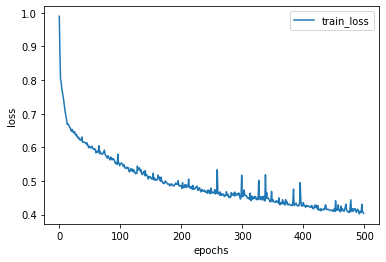

In [12]:
from __future__ import division
from __future__ import print_function
import time
import argparse  # argparse 是python自带的命令行参数解析包，可以用来方便地读取命令行参数
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

# Training settings
learning_rate = 0.01
weight_decay = 5e-4
epoch_num = 500
dropout = 0.02
#in_size = node_features  #设置输入层的维数
hi_size = 16 # 16 #设置隐藏层的维数
#out_size = node_label #设置输入层的维数


# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data(Adj,features,labels)

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=hi_size,
            nclass=labels.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

# 数据写入cuda，便于后续加速

# if args.cuda:
#     model.cuda()   # . cuda()会分配到显存里（如果gpu可用）
#     features = features.cuda()
#     adj = adj.cuda()
#     labels = labels.cuda()
#     idx_train = idx_train.cuda()
#     idx_val = idx_val.cuda()
#     idx_test = idx_test.cuda()
#global node_vec
train_loss = []
def train(epoch_num):
  t = time.time()  # 返回当前时间
  model.train()
  optimizer.zero_grad()
  # optimizer.zero_grad()意思是把梯度置零，也就是把loss关于weight的导数变成0.
  # pytorch中每一轮batch需要设置optimizer.zero_gra
  global Emdebding_train, output
  output, Emdebding_train = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  train_loss.append(loss_train)
  # 由于在算output时已经使用了log_softmax，这里使用的损失函数就是NLLloss，如果前面没有加log运算，
  # 这里就要使用CrossEntropyLoss了
  # 损失函数NLLLoss() 的输入是一个对数概率向量和一个目标标签. 它不会为我们计算对数概率，
  # 适合最后一层是log_softmax()的网络. 损失函数 CrossEntropyLoss() 与 NLLLoss() 类似,
  # 唯一的不同是它为我们去做 softmax.可以理解为：CrossEntropyLoss()=log_softmax() + NLLLoss()
  # https://blog.csdn.net/hao5335156/article/details/80607732
  acc_train = accuracy(output[idx_train], labels[idx_train])  #计算准确率
  loss_train.backward()  # 反向求导  Back Propagation
  optimizer.step()  # 更新所有的参数  Gradient Descent
    
  #if not args.fastmode:
      # Evaluate validation set performance separately,
      # deactivates dropout during validation run.
  model.eval()  # eval() 函数用来执行一个字符串表达式，并返回表达式的值
  global Emdebding_eval
  output, Emdebding_eval = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])    # 验证集的损失函数
  acc_val = accuracy(output[idx_val], labels[idx_val])
  print('Epoch: {:04d}'.format(epoch+1),     
        'loss_train: {:.4f}'.format(loss_train.item()),
        'acc_train: {:.4f}'.format(acc_train.item()),
        'loss_val: {:.4f}'.format(loss_val.item()),
        'acc_val: {:.4f}'.format(acc_val.item()),
        'time: {:.4f}s'.format(time.time() - t))

# 定义测试函数，相当于对已有的模型在测试集上运行对应的loss与accuracy
def test():
  model.eval()
  global Emdebding_test
  output, Emdebding_test = model(features, adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))

# Train model  逐个epoch进行train，最后test
t_total = time.time()
for epoch in range(epoch_num):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
test()
import matplotlib.pyplot as plt
import time
epochs = len(train_loss)
plt.plot(range(0,epochs,1), train_loss, label='train_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/"+time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))+"Unet-过拟合C0.jpg")
plt.show()

建立NeuMF层模型

In [13]:
import numpy as np
import theano
import theano.tensor as T
import keras
from keras import backend as K
from keras import initializers
#from keras import initializations
#from keras.regularizers import l1, l2, l1l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from time import time
import sys
import argparse
import scipy.sparse as sp
import numpy as np

使用数据生成正负样本

In [14]:
def load_rating_file_as_matrix(filename):
  '''
  Read .rating file and Return dok matrix.
  The first line of .rating file is: num_users\t num_items
  '''
  # Get number of users and items
  num_users, num_items = 0, 0
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      u, i = int(arr[0]), int(arr[1])
      num_users = max(num_users, u)
      num_items = max(num_items, i)
      line = f.readline()
  # Construct matrix
  print(num_users)
  print(num_items)
  mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      #user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
      #if (rating > 0):
      user, item = int(arr[0]), int(arr[1])
      mat[user, item] = 1.0
      line = f.readline()    
  return mat

In [15]:
filename = '/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum.csv'
train_Martrix = load_rating_file_as_matrix(filename)
train_Martrix

266
836


<267x837 sparse matrix of type '<class 'numpy.float32'>'
	with 17414 stored elements in Dictionary Of Keys format>

将vector of each nodes construct a serise of pairs of nodes

In [17]:
def get_train_instances(train, num_negatives):
  global user_input,item_input
  user_input, item_input, labels = [],[],[]
  num_users, num_items = train.shape
  for (u, i) in train.keys():
    # positive instance
    user_input.append(u)
    item_input.append(i)
    labels.append(1)
    # negative instances
    for t in range(num_negatives):
      j = np.random.randint(num_users,num_items)
      while (u, j) in train.keys():
        j = np.random.randint(num_users,num_items)
      user_input.append(u)
      item_input.append(j)
      labels.append(0)
  # 遍历生成NeuMF需要的drug的vecter
  drug_latent_vector, disease_latent_vector = [], []
  for i in user_input:
    drug_latent_vector.append(Emdebding_train[i].detach().numpy())
  for j in item_input:
    disease_latent_vector.append(Emdebding_train[j].detach().numpy())
  return drug_latent_vector, disease_latent_vector, labels

In [8]:
 from keras.layers.merge import multiply, concatenate
 import numpy as np
 drug_Embedded = [[1,2,3],[4,5,6],[4,5,6]]
 disease_Embedded = [[1,2,3],[4,5,6],[4,5,6]]
 mf_vector = concatenate([np.array(drug_Embedded), np.array(disease_Embedded)], axis = 0 )
 mf_vector

<tf.Tensor: shape=(6, 3), dtype=int64, numpy=
array([[1, 2, 3],
       [4, 5, 6],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6],
       [4, 5, 6]])>

In [210]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(drug_latent_vector, labels, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(disease_latent_vector, labels, test_size=0.2, random_state=42)

In [212]:
len(X_train2)

27862

In [187]:
Emdebding_train[31]

tensor([0.1258, 0.0000, 0.0000, 0.0000, 0.1699, 0.1190, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1654, 0.0000, 0.0000, 0.0000, 0.0000],
       grad_fn=<SelectBackward>)

In [204]:
x = X_train1[0]
(Emdebding_train.detach().numpy() == 0.26566425 ).nonzero()

(array([269]), array([0]))

In [28]:
np.array(X_train1).shape

(27862, 16)

In [200]:
X_train2[3]

array([0.26566425, 0.07014281, 0.        , 0.        , 0.01957224,
       0.        , 0.02155467, 0.        , 0.19214466, 0.4725169 ,
       0.        , 0.33538467, 0.29436526, 0.2282042 , 0.25656098,
       0.        ], dtype=float32)

In [201]:
y_train1[3]

0

In [202]:
y_train2[3]

0

In [18]:
from keras.layers.merge import multiply, concatenate
from keras.layers import Input, Dense
def NeuMF_getmodel(layers=[10], reg_layers=[0], reg_mf=0):
  assert len(layers) == len(reg_layers)
  num_layer = len(layers) #Number of layers in the MLP
  # Input variables
  drug_Embedded = Input(shape=(16,))
  disease_Embedded = Input(shape=(16,))
  
  mf_vector = multiply([drug_Embedded, disease_Embedded])
  # mf_vector = merge([drug_Embedded, disease_Embedded], mode='mul') # element-wise multiply

  # MLP part 
  mlp_vector = concatenate([drug_Embedded, disease_Embedded])
  # mlp_vector = merge([drug_Embedded, disease_Embedded], mode='concat')
  for idx in range(1, num_layer):
    layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    mlp_vector = layer(mlp_vector)

  # Concatenate MF and MLP parts
  predict_vector = concatenate([mf_vector, mlp_vector])
  # predict_vector = merge([mf_vector, mlp_vector], mode='concat')  
  # Final prediction layer
  prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = "prediction")(predict_vector) # sigmoid
    
  model = Model(input=[drug_Embedded, disease_Embedded],output=prediction)
  return model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", name="prediction", kernel_initializer="lecun_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Epoch: 0001 loss_train: 0.5904 acc_train: 0.7886
Epoch: 0002 loss_train: 0.5166 acc_train: 0.7990
Epoch: 0003 loss_train: 0.5095 acc_train: 0.7992
Epoch: 0004 loss_train: 0.5039 acc_train: 0.7993
Epoch: 0005 loss_train: 0.5014 acc_train: 0.7993
Epoch: 0006 loss_train: 0.5002 acc_train: 0.7994
Epoch: 0007 loss_train: 0.4995 acc_train: 0.7994
Epoch: 0008 loss_train: 0.4989 acc_train: 0.7995
Epoch: 0009 loss_train: 0.4987 acc_train: 0.7995
Epoch: 0010 loss_train: 0.4983 acc_train: 0.7994
Epoch: 0011 loss_train: 0.4982 acc_train: 0.7994
Epoch: 0012 loss_train: 0.4980 acc_train: 0.7994
Epoch: 0013 loss_train: 0.4977 acc_train: 0.7995
Epoch: 0014 loss_train: 0.4975 acc_train: 0.7995
Epoch: 0015 loss_train: 0.4975 acc_train: 0.7994
Epoch: 0016 loss_train: 0.4972 acc_train: 0.7995
Epoch: 0017 loss_train: 0.4971 acc_train: 0.7995
Epoch: 0018 loss_train: 0.4971 acc_train: 0.7993
Epoch: 0019 loss_train: 0.4970 acc_train: 0.7994
Epoch: 0020 loss_train: 0.4968 acc_train: 0.7994
Epoch: 0021 loss_tra

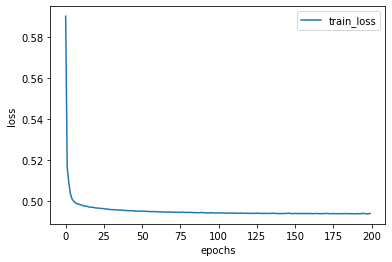

In [21]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split
num_epochs = 200
learning_rate = 0.001
num_negatives = 4 # 4  1
global num_scale 
num_scale = 69650 # 69650 27862
batch_size = 256

model = NeuMF_getmodel()
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics = ['accuracy'])
# load pima indians dataset
drug_latent_vector, disease_latent_vector, labels = get_train_instances(train_Martrix, num_negatives)

X_train1, X_test1, y_train1, y_test1 = train_test_split(drug_latent_vector, labels, test_size=0.2, random_state=2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(disease_latent_vector, labels, test_size=0.2, random_state=2)
train_loss = []
# Training model
for epoch in range(num_epochs):
  
  # Generate training instances
  # Training
  # hist = model.fit([np.array(drug_latent_vector[:num_scale]), np.array(disease_latent_vector[:num_scale])], #input 
  #                  np.array(labels[:num_scale]), # labels 
  #                  batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
  hist = model.fit([np.array(X_train1), np.array(X_train2)],  
                   np.array(y_train1), 
                   batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
  train_loss.append(hist.history['loss'][0])
  print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(hist.history['loss'][0]),
        'acc_train: {:.4f}'.format(hist.history['acc'][0]))
  
test_scores = model.evaluate([np.array(X_test1), np.array(X_test2)], y_test1)
print("Test set results:",
      "loss= {:.4f}".format(test_scores[0]),
      'acc_train: {:.4f}'.format(test_scores[1]))

import matplotlib.pyplot as plt
import time
epochs = len(train_loss)
plt.plot(range(0,epochs,1), train_loss, label='train_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/"+time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))+"Unet-过拟合C0.jpg")
plt.show()


AUC :  0.5910786627831873


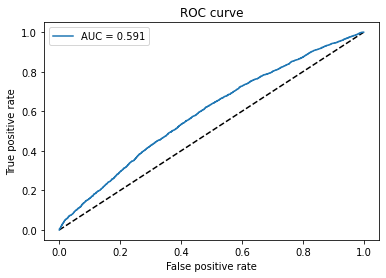

In [22]:
# 计算AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import time

y_score1 = model.predict([np.array(drug_latent_vector[num_scale:]), np.array(disease_latent_vector[num_scale:])])

now = time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time())) 
#Y_train0为真实标签，Y_pred_0为预测标签，注意，这里roc_curve为一维的输入，Y_train0是一维的
fpr, tpr, thresholds_keras = roc_curve(labels[num_scale:], y_score1)   
auc = auc(fpr, tpr)
print("AUC : ", auc)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/'+ now + 'ROC.jpg')
plt.show()

In [ ]:
# 归一化数据
from sklearn import preprocessing  
min_max_scaler = preprocessing.MinMaxScaler()  #标准化训练集数据 
data_train_nomal = min_max_scaler.fit_transform(y_score1)  #对测试集数据进行相同的归一化处理
data_train_nomal[:10]

In [ ]:
print('max:', data_train_nomal.max())
print('min:', data_train_nomal.min())

In [ ]:
def auc_calculate(labels,preds,n_bins=17420):
    postive_len = sum(labels)   #正样本数量（因为正样本都是1）
    negative_len = len(labels) - postive_len #负样本数量
    print('负样本数量:', negative_len)
    total_case = postive_len * negative_len #正负样本对
    pos_histogram = [0 for _ in range(n_bins)] 
    neg_histogram = [0 for _ in range(n_bins)]
    bin_width = 1.0 / n_bins
    for i in range(len(labels)):
        nth_bin = int(preds[i]/bin_width)
        if labels[i]==1:
            pos_histogram[nth_bin] += 1
        else:
            neg_histogram[nth_bin] += 1
    accumulated_neg = 0
    satisfied_pair = 0
    for i in range(n_bins):
        satisfied_pair += (pos_histogram[i]*accumulated_neg + pos_histogram[i]*neg_histogram[i]*0.5)
        accumulated_neg += neg_histogram[i]
    return satisfied_pair / float(total_case)
print("验证:",auc_calculate(labels[27862:], y_score1))

In [ ]:
from sklearn import metrics
'''使用real.csv和result.csv列数据，计算PR曲线的AUC值'''
precision, recall, _thresholds = metrics.precision_recall_curve(labels[69650:], data_train_nomal)
area = metrics.auc(recall, precision)
print(area) 